In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from transformers import CLIPModel, CLIPProcessor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import glob
import os 
from PIL import Image
import cv2
import torch.nn.functional as F
import torch.nn as nn 
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim
import tqdm


/home/moonlab/Reid/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed:int = 42)-> None:
    """Seed is being set for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42) # Setting the seed so that whenever we try to run the notebook again we get the same results.

In [3]:
class config:
    """Class to set up the configuration parameters"""
    def __init__(self)-> None:
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Defining the paths to the directories
        self.train_image_dir = "/home/moonlab/Reid/data/veri_dataset/image_train"
        self.query__image__dir = "/home/moonlab/Reid/data/veri_dataset/image_query"
        self.gallery__image__dir = "/home/moonlab/Reid/data/veri_dataset/image_gallery"

        # Defining the Model Settings 
        self.clip_model_name="openai/clip-vit-base-patch32"
        self.image_size=(256,256)

        # Defining the Model Parameters
        self.batch_size=32
        self.num_workers=4
        self.learning_rate=1e-4
        self.epochs=60
        

        # Defining the dimensions
        self.num_classes=85
        self.feat_dim=2048
        self.clip_dim=512



cfg=config()
cfg.device


        

## Till now we have successfully set up the configuration and seeds.

'cuda'

(np.float64(-0.5), np.float64(1197.5), np.float64(422.5), np.float64(-0.5))

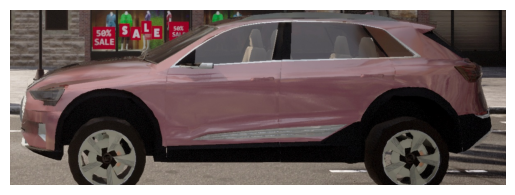

In [4]:
## lets visualize some images from the dataset
image_path1="/home/moonlab/Reid/data/veri_dataset/image_train/20220715035833_26_330.jpg"
image=cv2.imread(image_path1)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.axis("off")



In [5]:
class CarlaVeriDataset(Dataset):
    """This class inherits from the Dataset class of pytorch, hence we will define 
        The required 3 methods __init_, __len__ and __getitem__"""


    """Custom class for loading the Veri Dataset
        The Veri dataset has been taken from the following link:
        <https://github.com/sekilab/VehicleReIdentificationDataset?tab=readme-ov-file>
        @INPROCEEDINGS{10020814,
        author={Kumar, Ashutosh and Kashiyama, Takehiro and Maeda, Hiroya and Zhang, Fan and Omata, Hiroshi and Sekimoto, Yoshihide},
        booktitle={2022 IEEE International Conference on Big Data (Big Data)}, 
        title={Vehicle re-identification and trajectory reconstruction using multiple moving cameras in the CARLA driving simulator}, 
        year={2022},
        volume={},
        number={},
        pages={1858-1865},
        doi={10.1109/BigData55660.2022.10020814}}
        
        
        The dataset that we are using contains synthetic images of vehciles captured in the carla simulator.
        There are 85 camera's starting from 0 to 84 and each vehicle passes through these 85 camera's. """
    
    def __init__(self, dir_path:str, transform=None)->None:
        self.dir_path=dir_path
        self.transform=transform

        # get all the image_paths
        self.image_path=glob.glob(os.path.join(self.dir_path, "*.jpg"))
        self.image_path=sorted(self.image_path)

        if self.image_path is None:
            print("There are no images in the directory.")

        self.pids=[] # This is there to store the vehicle ids
        self.camids=[] # This is there to store the camera ids

        self.valid_paths=[]
        for paths in self.image_path:
            filename=os.path.basename(paths).replace(".jpg","")
            parts=filename.split("_")

            if len(paths)>=3:
                pid=int(parts[1])
                camid=int(parts[2])

                self.pids.append(pid)
                self.camids.append(camid)
                self.valid_paths.append(paths)
        self.image_path=self.valid_paths

        """Note: The PIDS that we have here are not continuous so we have to make sure that they are continous value 
        starting from 0 to num_classes-1, Otherwise our model will collapse during training"""

        self.unique_pids=sorted(list(set(self.pids)))
        self.pid_maps={old:new for new,old in enumerate(self.unique_pids)}
        self.new_pids=[self.pid_maps[p] for p in self.pids]

        print(f"Total images: {len(self.image_path)} Total unique pids: {len(self.unique_pids)}")
        
        
    def __len__(self)-> int:
        return len(self.image_path)
    
    def __getitem__(self, index:int)-> tuple:
        """ This fnction fetches you the image and the corresponding labels"""
        path=self.image_path[index]
        camid=self.camids[index]
        pid=self.new_pids[index]
        original_pid=self.pids[index]

        image=cv2.imread(path)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=Image.fromarray(image)
        if self.transform is not None:
            image=self.transform(image)

        return image, pid, camid,original_pid,path
            

        



In [6]:
## lets define the transforms for the dataset
train_transforms=T.Compose([
    T.Resize((256,256)),
    T.RandomHorizontalFlip(),
    T.Pad(10),
    T.RandomCrop(256,256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

## lets execute the verification on the train dataset
train_directory=cfg.train_image_dir
train_dataset=CarlaVeriDataset(dir_path=train_directory, transform=train_transforms)

Total images: 50949 Total unique pids: 85


In [7]:
train_dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [8]:
class IBN(nn.Module):
    """
    This class implements the Instance-Batch Normalization Layer. 
    NOTE:" Why Instance-Batch Normalization Layer?
    The ResNet that we are implementing here is not the standard ResNet,
    But a modified ResNet with IBN layers.

    Standard ResNet uses Batch Normalization that normalizes the features across the entire batch.
    Instance Normalization normalizes the features for each instance in the batch seperately.


    IN IBN, the feature channels are split into two parts: one part undersgoes Instance Normalization, while the other part goes to the Batch Normalization.
    """

    def __init__(self,planes:int)-> None:
        """In this class we pass the number of feature planes as input"""
        super(IBN,self).__init__()
        half1=int(planes/2)
        half2=planes-half1

        self.IN =nn.InstanceNorm2d(half1,affine=True)
        self.BN=nn.BatchNorm2d(half2)


            
    def forward(self,x:torch.Tensor)-> torch.Tensor:
        """This function defines the forward pass of the IBN Layer"""
        split_size = x.size(1) // 2
        split=torch.split(x, split_size,1)

        out1=self.IN(split[0].contiguous())
        out2=self.BN(split[1].contiguous())


        out=torch.cat((out1,out2),1)
        return out


In [9]:
ibn=IBN(256)
ibn

IBN(
  (IN): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (BN): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [10]:
class BottleneckIBN(nn.Module):
    """This class defines how or convolution layers should be looking but including the Instance Batch Normalization BottleNeck"""
    expansion=4
    def __init__(self, inplanes, planes, strides=1, downsample=None):
        super(BottleneckIBN,self).__init__()

        self.conv1=nn.Conv2d(in_channels=inplanes,out_channels=planes,kernel_size=1,bias=False)
        self.bn1=IBN(planes)

        self.conv2=nn.Conv2d(in_channels=planes, out_channels=planes, padding=1, kernel_size=3, stride=strides, bias=False)
        self.bn2=nn.BatchNorm2d(planes)

        self.conv3=nn.Conv2d(in_channels=planes, out_channels=planes*self.expansion,kernel_size=1, bias=False)
        self.bn3=nn.BatchNorm2d(planes*self.expansion)

        self.relu=nn.ReLU(inplace=True)

        self.downsample=downsample
        self.strides=strides


    def forward(self,x: torch.Tensor)-> torch.Tensor:
        identity=x
        out=self.conv1(x)
        out=self.bn1(out)
        out=self.relu(out)

        out=self.conv2(out)
        out=self.bn2(out)
        out=self.relu(out)

        out=self.conv3(out)
        out=self.bn3(out)

        if self.downsample is not None:
            identity=self.downsample(x)

        out+=identity
        out=self.relu(out)

        return out

        

    


In [11]:
class ResNetIBN(torch.nn.Module):
    """In this module we will define the ResNet50 architecture as the feature extractor"""
    def __init__(self,config):
        super(ResNetIBN,self).__init__()
        self.model=resnet50(weights=ResNet50_Weights.DEFAULT)
        layer1_layers=[]

        layer1_layers.append(BottleneckIBN(64,64,strides=1,downsample=self.model.layer1[0].downsample))
        layer1_layers.append(BottleneckIBN(256,64,strides=1))
        layer1_layers.append(BottleneckIBN(256,64,strides=1))


        self.model.layer1=nn.Sequential(*layer1_layers)
        self.model.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.model.fc=nn.Identity()

        self.model.out_dim=2048


    def forward(self,x):
        features=self.model(x)
        return features
        

        


In [12]:
class SemanticExtractionModule(nn.Module):
    """
    This class defines the semantic extraction module  using the ClipVector
    Here we input the image tensor and get the CLS token as the semantic vector representation of the image.
    Here the pooler output that we are taking is the CLS token representation of the image. 
    """
    def __init__(self,config):
        super(SemanticExtractionModule,self).__init__()
        self.clip=CLIPModel.from_pretrained(config.clip_model_name)

        self.vision_model = self.clip.vision_model
        
        # 2. The Projection Layer (Maps 768 -> 512 dim)
        self.visual_projection = self.clip.visual_projection
        
        # Freeze everything to save memory/compute
        for param in self.vision_model.parameters():
            param.requires_grad = False
        for param in self.visual_projection.parameters():
            param.requires_grad = False
        self.output_dim=config.clip_dim


    def forward(self,x:torch.Tensor)-> torch.Tensor:
        vision_outputs=self.vision_model(pixel_values=x,interpolate_pos_encoding=True)
        semantic_features=vision_outputs.pooler_output
        semantic_features = self.visual_projection(semantic_features)

        return semantic_features

In [13]:
class FusionModule(nn.Module):
    """This class is the fusion module that fuses the features that we get from the ResNetIBN and the semantic extraction module"""
    def __init__(self,config):
        super(FusionModule,self).__init__()

        self.feat_dim=config.feat_dim
        self.clip_dim=config.clip_dim


        self.dim_reduce=nn.Sequential(
            nn.Linear(in_features=self.feat_dim+self.clip_dim,out_features=self.feat_dim,bias=False),
            nn.BatchNorm1d(self.feat_dim),
            nn.ReLU(inplace=True))
        


    def forward(self, visual_features:torch.Tensor, semantic_features:torch.Tensor)-> torch.Tensor:
        f1=visual_features.view(visual_features.size(0),-1)
        f2=semantic_features.view(semantic_features.size(0),-1)

        fused_features=torch.cat((f1,f2),dim=1)
        fused_features=self.dim_reduce(fused_features)
        return fused_features
        
        

In [14]:
class AFEMModule(torch.nn.Module):
    """
    This class defines the Adaptive Feature Enhancement Module as discussed in the paper 

    """

    def __init__(self, in_dim,out_dim, groups):
        super(AFEMModule,self).__init__()

        self.groups=groups
        self.in_dim=in_dim

        self.f_linear=nn.Sequential(
            nn.Linear(in_dim,out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(inplace=True)
        )

        """
        The 512 dimensional feature vector that we got from the clip image encoding we are passing it that to the semantic feature enhancement module module.
        where the vectors are first past through a linear MLP, Batch Normalization and ReLU activation function.
        Then since we have decided that the number of groups that we have is 32 so based on the semantic vector dimension we will divide the semantic vector into the respective groups and

        """

        ## Lets define the parameter weights

        self.W = nn.Parameter(torch.tensor(torch.zeros(1, groups) + 1e-3))


    def forward(self,t_s):
        x=self.f_linear(t_s)

        batch,dim=x.shape
        channels_per_group= dim//self.groups
        """Here we are dividing the the features into groups"""

        x_grouped=x.view(batch,self.groups,channels_per_group)
        expanded_weights=self.W.view(1, self.groups, 1)
        weighted_groups=x_grouped*expanded_weights

        weighted_out=weighted_groups.view(batch,dim)

        ts_prime=x+weighted_out

        return ts_prime

        

In [15]:
class CLIP_SENet(nn.Module):
    """This class is defined so that  whatever we have build till now we can use that up."""
    
    def __init__(self,config)->None:
        super(CLIP_SENet,self).__init__()

        # Lets call the apprearence backbone
        self.backbone=ResNetIBN(config)
        self.gap=nn.AdaptiveAvgPool2d(1)

        # Lets call the semantic module

        self.sem_module=SemanticExtractionModule(config)
        self.sem_bn=nn.BatchNorm1d(config.clip_dim)

        self.afem=AFEMModule(in_dim=config.clip_dim, out_dim=config.feat_dim,groups=32)

        self.fusion_module=FusionModule(config=config)

        self.bottleneck=nn.BatchNorm1d(config.feat_dim)
        self.classifier=nn.Linear(in_features=config.feat_dim, out_features=cfg.num_classes,bias=False)

        self.identity_loss=nn.CrossEntropyLoss()
        self.trip_loss=nn.TripletMarginLoss(margin=0.3)


    def forward(self,images:torch.tensor,labels):
        """Here the input is the iamge of B,C,H,W and the batch of the ground truth of the labels """
        ta=self.backbone(images)
        ts=self.sem_module(images)
        ts=self.sem_bn(ts)

        ts_prime=self.afem(ts)

        fusion=self.fusion_module(ta,ts)

        t=ts_prime + fusion

        feat_norm=self.bottleneck(t)
        logits=self.classifier(t)

        


        return t,logits



        



In [16]:
class LossWrapper(nn.Module):
    def __init__(self,num_classes,epsilon=0.1, temperature=0.07):
        super(LossWrapper,self).__init__()

        self.ce_loss=nn.CrossEntropyLoss(label_smoothing=epsilon)
        self.temperature=temperature


    def supercon_loss(self,features,labels):
        """In the supercontrastive loss we push the positive and negative pairs apart and pull close the positive pair"""
        device=cfg.device
        batch_size=features.shape[0]

        features= F.normalize(features,dim=1)

        similarity_matrix=torch.matmul(features,features.T)

        labels=labels.contiguous().view(-1,1)
        mask=torch.eq(labels,labels.T).float().to(device)
        logit_masks=torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size).view(-1,1).to(device),
            0
        )
        mask=mask*logit_masks
        logits=similarity_matrix / self.temperature

        logits_max,_=torch.max(logits,dim=1,keepdim=True)
        logits=logits-logits_max.detach()


        exp_logits=torch.exp(logits)*logit_masks
        log_prob=logits-torch.log(exp_logits.sum(1,keepdim=True)+1e-12)

        mask_pos_pairs = mask.sum(1)
        
        # Avoid division by zero: 
        # If an anchor has no positives, set divisor to 1 (loss becomes 0 for that sample)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, torch.ones_like(mask_pos_pairs), mask_pos_pairs)

        mean_log_prob_pos=(mask*log_prob).sum(1) / mask_pos_pairs
        loss=-mean_log_prob_pos.mean()


        return loss
    
    def forward(self,cls_score,features,targets):
        ce_loss=self.ce_loss(cls_score,targets)
        sc_loss=self.supercon_loss(features,targets)
        total_loss= ce_loss+sc_loss

        return total_loss,ce_loss,sc_loss
    

    



        
    

In [17]:
# import tqdm
# import torch
# import torchvision.transforms as T
# from torch.utils.data import DataLoader

# def train():
#     # --- 1. TRANSFORMS & DATA ---
#     train_transforms = T.Compose([
#         T.Resize((256, 256)),
#         T.RandomHorizontalFlip(),
#         T.Pad(10),
#         T.RandomCrop(256, 256),
#         T.ToTensor(),
#         T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])
#     print("Transformations done! Loading the data .....")

#     train_dataset = CarlaVeriDataset(dir_path=cfg.train_image_dir, transform=train_transforms)
#     cfg.num_classes = len(train_dataset.unique_pids)
    
#     # Note: Ideally, switch shuffle=True to the RandomIdentitySampler discussed earlier for better SC loss
#     train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)

#     print("Dataset Loaded! Initializing the Model")
#     model = CLIP_SENet(cfg).to(cfg.device)
#     criterion = LossWrapper(num_classes=cfg.num_classes).to(cfg.device)

#     # --- 2. GRADIENT CHECK ---
#     print("Model Initialization done! Doing the Gradients Safety Check")
#     trainable_params = 0
#     frozen_params = 0

#     print(f" {'Module':<25} | {'Status':<10} | {'Params'}")
#     print("-" * 50)

#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             trainable_params += param.numel()
#         else:
#             frozen_params += param.numel()

#     print("-" * 50)
#     print(f"Trainable Params: {trainable_params}")
#     print(f"Frozen Params: {frozen_params}")

#     if frozen_params == 0:
#         print(" Warning! The clip encoder is not frozen ... Recheck the Clip Module")
#     else:
#         print("Success")

#     optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=5e-4)

#     # --- 3. TRAINING LOOP ---
#     print("\nStarting Training...")
#     model.train()

#     # Enable Anomaly Detection (Optional: Disable this later for speed if stable)
#     torch.autograd.set_detect_anomaly(True)

#     for epoch in range(cfg.epochs):
#         # Initialize accumulators for the epoch
#         total_loss = 0.0
#         total_ce = 0.0
#         total_sc = 0.0
#         num_batches = 0
        
#         loop = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.epochs}")
        
#         for images, labels, camids, original_pids, paths in loop:
#             images = images.to(cfg.device)
#             labels = labels.to(cfg.device)

#             optimizer.zero_grad()

#             # Forward Pass
#             features, logits = model(images, labels)
            
#             # NaN Check
#             if torch.isnan(features).any():
#                 print("NaN detected in Features! Skipping Batch.")
#                 continue

#             # Loss Calculation
#             loss, ce, sc = criterion(logits, features, labels)

#             # Backward Pass
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
#             optimizer.step()
            
#             # Accumulate metrics
#             total_loss += loss.item()
#             total_ce += ce.item()
#             total_sc += sc.item()
#             num_batches += 1
            
#             # Update Progress Bar (shows current batch loss)
#             loop.set_postfix(loss=loss.item(), ce=ce.item(), sc=sc.item())

#         # --- END OF EPOCH STATS ---
#         # Calculate averages
#         avg_loss = total_loss / num_batches if num_batches > 0 else 0
#         avg_ce = total_ce / num_batches if num_batches > 0 else 0
#         avg_sc = total_sc / num_batches if num_batches > 0 else 0
        
#         # Print clearly
#         print(f"\nEpoch [{epoch+1}/{cfg.epochs}] Summary:")
#         print(f"  Avg Total Loss: {avg_loss:.4f}")
#         print(f"  Avg CE Loss:    {avg_ce:.4f}")
#         print(f"  Avg SC Loss:    {avg_sc:.4f}")
#         print("-" * 30)
        
#         # Save Checkpoint
#         torch.save(model.state_dict(), "latest_model.pth")

# if __name__ == "__main__":
#     train()

Loading weights from: latest_model.pth


/tmp/ipykernel_317411/274845811.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.W = nn.Parameter(torch.tensor(torch.zeros(1, groups) + 1e-3))


Processing Query: 20220712132413_32_38.jpg
Scanning gallery...


100%|██████████| 3823/3823 [00:32<00:00, 117.99it/s]


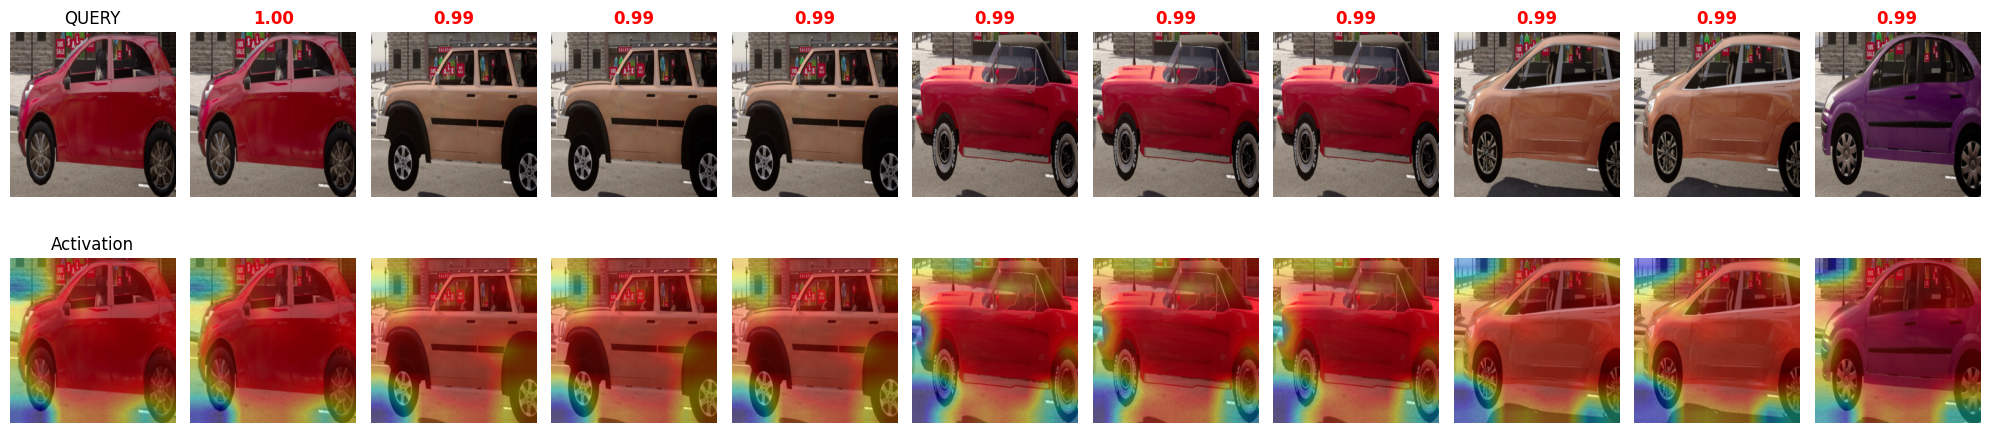

In [ ]:
inference_transforms = T.Compose([
    T.Resize(cfg.image_size),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def load_trained_model(weights_path):
    print(f"Loading weights from: {weights_path}")
    state_dict = torch.load(weights_path, map_location=cfg.device)
    
    
    if 'classifier.weight' in state_dict:
        trained_classes = state_dict['classifier.weight'].shape[0]
        cfg.num_classes = trained_classes
    
    model = CLIP_SENet(cfg).to(cfg.device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


def get_embedding(model, image_path):
    img = Image.open(image_path).convert('RGB')
    img_tensor = inference_transforms(img).unsqueeze(0).to(cfg.device)
    
   
    dummy_label = torch.zeros(1).long().to(cfg.device)
    
    with torch.no_grad():
        
        features, _ = model(img_tensor, dummy_label)
        
    return F.normalize(features, p=2, dim=1).cpu()


def generate_heatmap_overlay(model, img_path):
   
    img_pil = Image.open(img_path).convert('RGB').resize((256, 256))
    img_tensor = inference_transforms(img_pil).unsqueeze(0).to(cfg.device)
    
   
    dummy_label = torch.zeros(1).long().to(cfg.device)
    
    
    model.eval()
    with torch.no_grad():
        
        _ = model(img_tensor, dummy_label)
    
    
    feature_map = activations['last_conv']
    
    
    heatmap = torch.mean(feature_map, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0) 
    heatmap /= (heatmap.max() + 1e-8) 
    heatmap = cv2.resize(heatmap, (256, 256))
    
    
    img_np = np.array(img_pil)
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)
    
    return img_np, overlay


if __name__ == "__main__":
    
    
    model_path = "latest_model.pth"
    model = load_trained_model(model_path)
    

    target_layer = model.backbone.model.layer4 
    target_layer.register_forward_hook(get_activation('last_conv'))
    
    # C. Define Query (PASTE YOUR PATH HERE)
    MANUAL_QUERY_PATH = "/home/moonlab/Reid/data/veri_dataset/image_query/20220712132413_32_38.jpg"
    
    if not os.path.exists(MANUAL_QUERY_PATH):
        print(f"Error: Query path does not exist: {MANUAL_QUERY_PATH}")
    else:
        print(f"Processing Query: {os.path.basename(MANUAL_QUERY_PATH)}")
        query_feat = get_embedding(model, MANUAL_QUERY_PATH)
        
        gallery_files = sorted(glob.glob(os.path.join(cfg.gallery__image__dir, "*.jpg")))
        gallery_feats_list = []
        valid_paths = []
        
        print("Scanning gallery...")
        for g_path in tqdm(gallery_files):
            try:
                feat = get_embedding(model, g_path)
                gallery_feats_list.append(feat)
                valid_paths.append(g_path)
            except Exception as e: 
                pass
            
        if len(gallery_feats_list) > 0:
            gallery_tensor = torch.cat(gallery_feats_list, dim=0)
            
            
            scores = torch.mm(query_feat, gallery_tensor.t())
            top_k_scores, top_k_indices = torch.topk(scores, k=10, dim=1)
            
           
            plt.figure(figsize=(20, 5))
            
            
            q_orig, q_heat = generate_heatmap_overlay(model, MANUAL_QUERY_PATH)
            
            plt.subplot(2, 11, 1)
            plt.imshow(q_orig)
            plt.title("QUERY")
            plt.axis("off")
            
            plt.subplot(2, 11, 12)
            plt.imshow(q_heat)
            plt.title("Activation")
            plt.axis("off")
            
            
            top_indices = top_k_indices[0].cpu().numpy()
            top_vals = top_k_scores[0].cpu().numpy()
            
            for i, idx in enumerate(top_indices):
                path = valid_paths[idx]
                score = top_vals[i]
                
                
                g_orig, g_heat = generate_heatmap_overlay(model, path)
                
               
                try:
                    q_id = os.path.basename(MANUAL_QUERY_PATH).split('_')[0]
                    g_id = os.path.basename(path).split('_')[0]
                    color = "green" if q_id == g_id else "red"
                except: color = "black"
                
                
                plt.subplot(2, 11, i + 2)
                plt.imshow(g_orig)
                plt.title(f"{score:.2f}", color=color, fontweight='bold')
                plt.axis("off")
                
                
                plt.subplot(2, 11, i + 13)
                plt.imshow(g_heat)
                plt.axis("off")
                
            plt.tight_layout()
            plt.show()
        else:
            print("No valid gallery images found.")